In [195]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.tomo import R
from holotomocupy.holo import G
from holotomocupy.magnification import M
from holotomocupy.shift import S
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

# Init data sizes and parametes of the PXM of ID16A

In [196]:
n = 256  # object size in each dimension

ntheta = 90  # number of angles (rotations)
noise = False


# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = sys.argv[2]=='True'
# z1p = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles

ndist = 4  # number of code positions
detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1p = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{ntheta}_{ndist}_{noise}_{z1p}'
# allow padding if there are shifts of the probe
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8
print(distances+distances2)

[0.00420013 0.00420013 0.00420013 0.00420013]


## Read real and imaginary parts of the refractive index u = delta+i beta

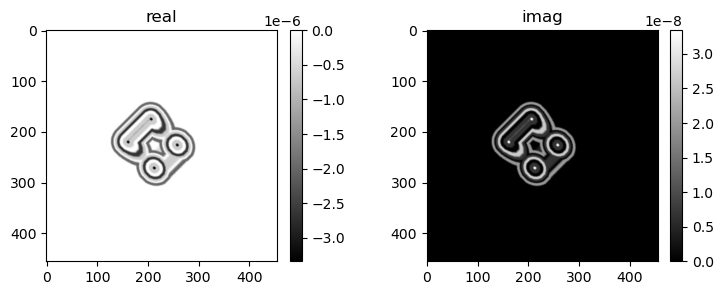

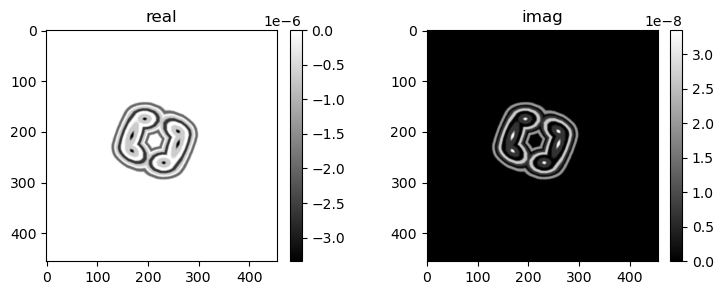

In [197]:
from scipy import ndimage

# cube_all = np.zeros([n, n, n], dtype='float32')
# rr = (np.ones(8)*n*0.25).astype(np.int32)
# amps = [3, -3, 1, 3, -4, 1, 4]  # , -2, -4, 5 ]
# dil = np.array([33, 28, 25, 21, 16, 10, 3])/256*n  # , 6, 3,1]
# for kk in range(len(amps)):
#     cube = np.zeros([n, n, n], dtype='bool')
#     r = rr[kk]
#     p1 = n//2-r//2
#     p2 = n//2+r//2
#     for k in range(3):
#         cube = cube.swapaxes(0, k)
#         cube[p1:p2, p1, p1] = True
#         cube[p1:p2, p1, p2] = True
#         cube[p1:p2, p2, p1] = True
#         cube[p1:p2, p2, p2] = True
#         # cube[p1:p2,p2,p2] = True

#     [x, y, z] = np.meshgrid(np.arange(-n//2, n//2),
#                             np.arange(-n//2, n//2), np.arange(-n//2, n//2))
#     circ = (x**2+y**2+z**2) < dil[kk]**2
#     # circ = (x**2<dil[kk]**2)*(y**2<dil[kk]**2)*(z**2<dil[kk]**2)

#     fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
#     fcube = np.fft.fftshift(np.fft.fftn(
#         np.fft.fftshift(cube.astype('float32'))))
#     cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
#     cube = cube > 1
#     cube_all += amps[kk]*cube

# # cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
# cube_all = ndimage.rotate(cube_all, 28, axes=(0, 1), reshape=False, order=3)
# cube_all = ndimage.rotate(cube_all, 45, axes=(0, 2), reshape=False, order=3)
# cube_all[cube_all < 0] = 0


# u0 = cube_all  # (-1*cube_all*1e-6+1j*cube_all*1e-8)/3

# u0 = np.roll(u0, -15*n//256, axis=2)
# u0 = np.roll(u0, -10*n//256, axis=1)
# v = np.arange(-n//2, n//2)/n
# [vx, vy, vz] = np.meshgrid(v, v, v)
# v = np.exp(-10*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
# u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real
# u0[u0 < 0] = 0
# u0 = u0*(-1*1e-6+1j*1e-8)/1.5
# u0 = u0.astype('complex64')  
# !mkdir -p data
# np.save('data/u', u0)


u = np.load('data/u.npy').astype('complex64')
u = np.pad(u,((ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)))

mshow_complex(u[:, ne//2])
mshow_complex(u[ne//2])


## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

128.0 (456, 456, 456)


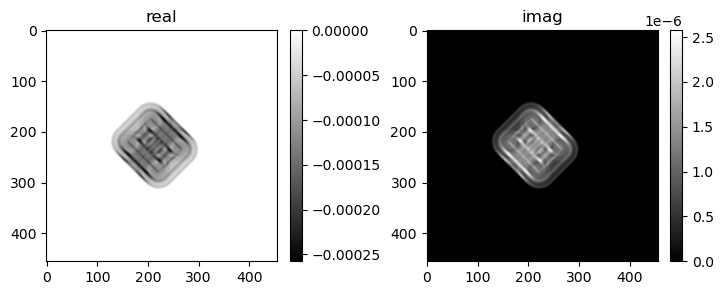

In [198]:
print(center,u.shape)
Ru = R(u, theta, center*ne/n)
Ru = Ru.swapaxes(0, 1)
mshow_complex(Ru[0])

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

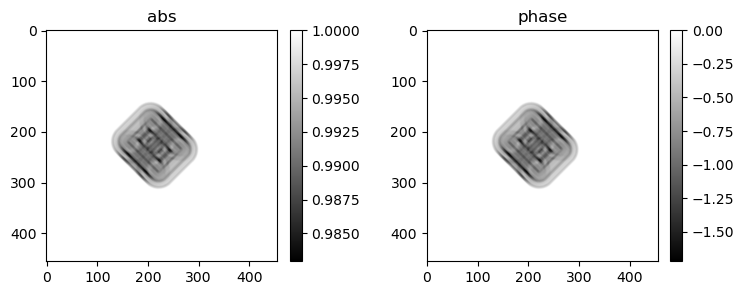

In [199]:
psi = np.exp(2*np.pi*1j/wavelength*voxelsize*Ru)

mshow_polar(psi[0])

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

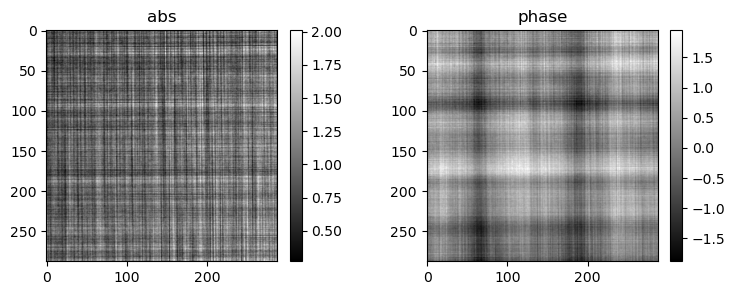

In [200]:
# !wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P ../data/prb_id16a
# !wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P ../data/prb_id16a

prb_abs = read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0:1]
prb_phase = read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


for k in range(2):
    prb = prb[:, ::2]+prb[:, 1::2]
    prb = prb[:, :, ::2]+prb[:, :, 1::2]/4

prb = prb[:, 128-pad:-128+pad, 128-pad:-128+pad]
prb /= np.mean(np.abs(prb))
# prb[:]=1

mshow_polar(prb[0])

# Smooth the probe, the loaded one is too noisy

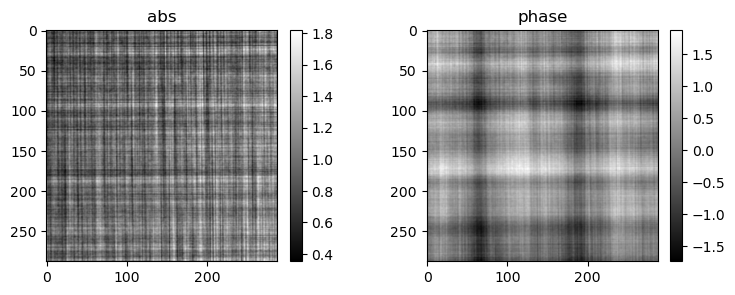

In [201]:
v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-5*(vx**2+vy**2))
prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')
# prb[:]=1
mshow_polar(prb[0])

# Shifts/drifts

In [202]:
# random sample shifts for each projection (note:before magnification)
shifts = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/32*0
# drift of the probe during collection of projections
shifts_ref = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/256*0  # typically small
# drift of the probe during collection of references
shifts_ref0 = (np.random.random([1, ndist, 2]).astype('float32')-0.5)*n/256*0

# use the first ref image as the global reference for illumination
shifts_ref0[0, 0, :] = 0

# shift of the sample when moving between differen planes
shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')
# use the first plane as the global reference for illumination
shifts_drift[:, 1] = np.array([0.6, 0.3])*0
shifts_drift[:, 2] = np.array([-1.3, 1.5])*0
shifts_drift[:, 3] = np.array([2.3, -3.5])*0

np.save('data/shifts', shifts)
np.save('data/shifts_drift', shifts_drift)
np.save('data/shifts_ref', shifts_ref)
np.save('data/shifts_ref0', shifts_ref0)

In [203]:
# sum sample random and drift shifts for simulations
shifts += shifts_drift

### Compute holographic projections for all angles and all distances
#### $d=\left|\mathcal{G}_{z_j}((\mathcal{G}_{z'_j}S_{s'_{kj}}q)(M_j S_{s_{kj}}\psi_k))\right|_2^2$, and reference data $d^r=\left|\mathcal{G}_{z'_j}S_{s^r_{j}}q\right|$

In [204]:
prb.shape

(1, 288, 288)

In [205]:
from holotomocupy.chunking import gpu_batch

@gpu_batch
def fwd_holo(psi, shifts_ref, shifts, prb):
    # print(prb.shape)
    prb = cp.array(prb)
    
    data = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for i in range(ndist):        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        
        prbr = S(prbr, shifts_ref[:,i])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        # object shift for each acquisition
        psir = S(psi, shifts[:,i]/norm_magnifications[i])      
        
        # scale object        
        if ne != n+2*pad:
            psir = M(psir, norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

@gpu_batch
def _fwd_holo0(prb, shifts_ref0):    
    data = cp.zeros([1,ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = S(prb, shifts_ref0[:,j])                 
        # propagate illumination 
        print(prbr.shape)
        data[:,j] = G(prbr, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb, shifts_ref0)

# print(prb.shape)
fpsi = fwd_holo(psi,shifts_ref,shifts,prb)
# fpsi0 = fwd_holo(psi*0+1,shifts_ref,shifts,prb)
fref = fwd_holo0(prb)

(1, 288, 288)
(1, 288, 288)
(1, 288, 288)
(1, 288, 288)


### Take squared absolute value to simulate data on the detector and a reference image

In [206]:
data = np.abs(fpsi)**2
# data0 = np.abs(fpsi0)**2
ref = np.abs(fref)**2

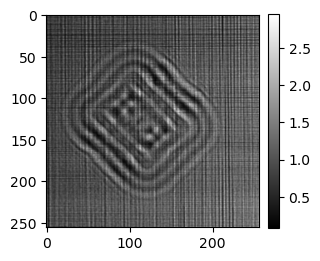

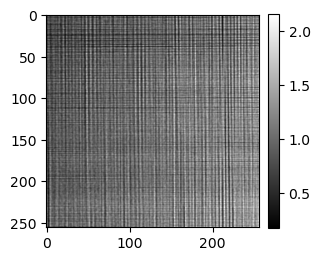

In [207]:
mshow(data[0,0])
mshow(ref[0,0])

### Visualize data

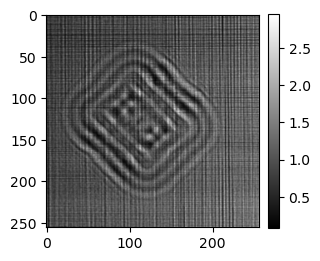

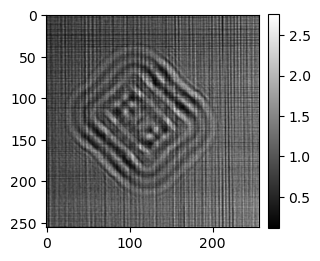

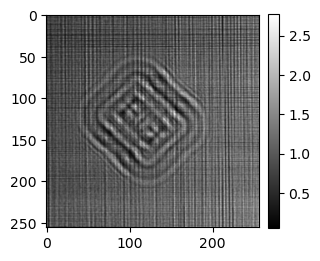

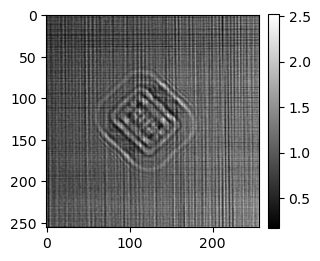

In [208]:
for k in range(ndist):
    mshow(data[0,k])


### Visualize reference images

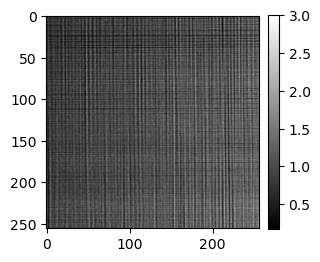

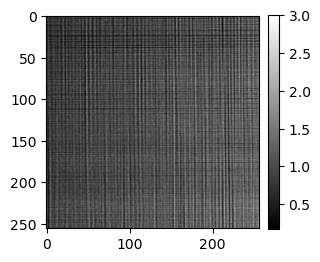

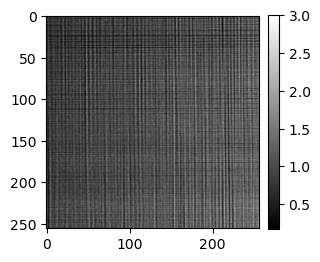

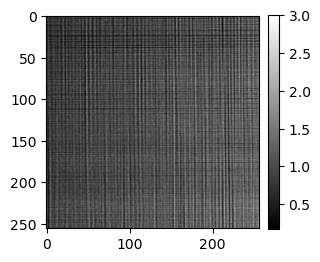

In [209]:
for k in range(ndist):
    mshow(ref[0,k],vmax=3)

### Save data, reference images

In [210]:
for k in range(len(distances)):
    write_tiff(data[:,k],f'data/data_3d_ald_{n}_{k}')
for k in range(len(distances)):
    write_tiff(ref[:,k],f'data/ref_3d_ald_{n}_{k}')

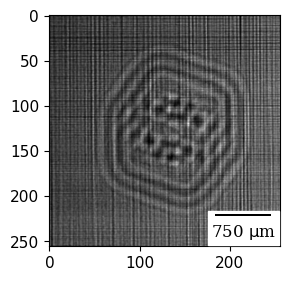

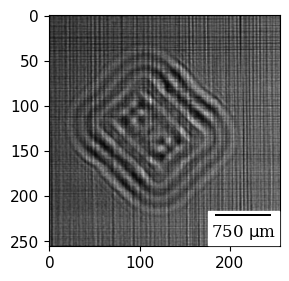

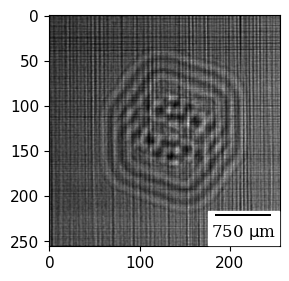

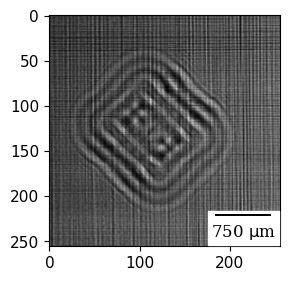

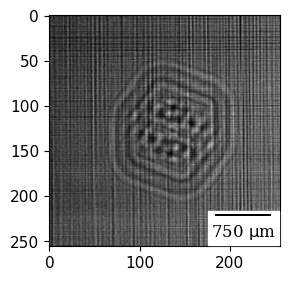

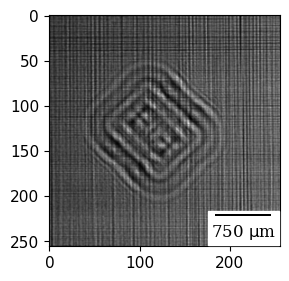

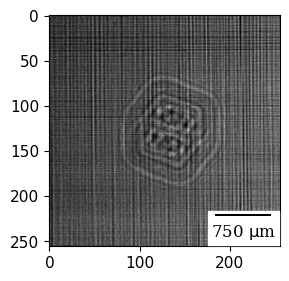

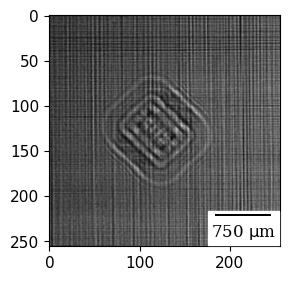

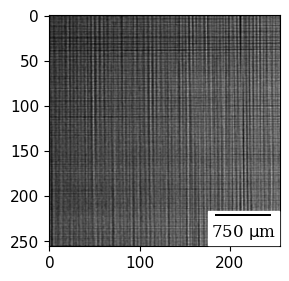

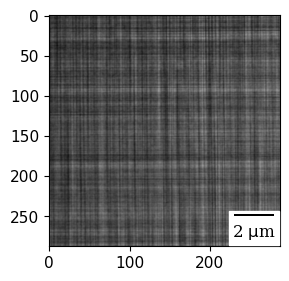

In [217]:
from matplotlib_scalebar.scalebar import ScaleBar
for k in range(ndist):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(data[ntheta//2,k],cmap='gray',vmin=0.2,vmax=2.8)
    scalebar = ScaleBar(voxelsize*magnifications[0], "m", length_fraction=0.25, font_properties={
            "family": "serif",
            "size": "large",
        },  # For more information, see the cell below
        location="lower right")
    ax.add_artist(scalebar)
    ax.tick_params(axis='both', which='major', labelsize=11)
    # plt.show()
    plt.savefig(f'fig/nocoded90deg{k}dist_prb.png',bbox_inches='tight',dpi=300)

    from matplotlib_scalebar.scalebar import ScaleBar
    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(data[0,k],cmap='gray',vmin=0.1,vmax=3)
    scalebar = ScaleBar(voxelsize*magnifications[0], "m", length_fraction=0.25, font_properties={
            "family": "serif",
            "size": "large",
        },  # For more information, see the cell below
        location="lower right")
    ax.add_artist(scalebar)
    # ax.xticks(fontsize=14)
    # ax.yticks(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=11)
    # fig.colorbar(im, ax=ax, orientation='vertical')

    # plt.show()
    plt.savefig(f'fig/nocoded0deg{k}dist_prb.png',bbox_inches='tight',dpi=300)

from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(ref[0,k],cmap='gray',vmin=0.2,vmax=2.8)
# fig.colorbar(im, ax=ax)
scalebar = ScaleBar(voxelsize*magnifications[0], "m", length_fraction=0.25, font_properties={
        "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    location="lower right")
ax.add_artist(scalebar)
# ax.xticks(fontsize=14)
# ax.yticks(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
# fig.colorbar(im, ax=ax, orientation='vertical')

# plt.show()
plt.savefig(f'fig/nocoded_prb.png',bbox_inches='tight',dpi=300)






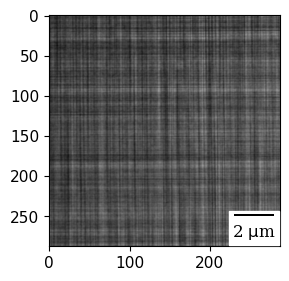

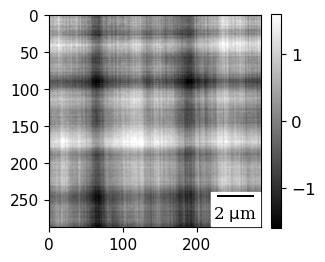

In [224]:
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(np.abs(prb[0]),cmap='gray',vmin=0.2,vmax=2.8)
# fig.colorbar(im, ax=ax)
scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
        "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    location="lower right")
ax.add_artist(scalebar)
# ax.xticks(fontsize=14)
# ax.yticks(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
cbar = fig.colorbar(im, ax=ax, orientation='vertical',fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12) 
# plt.show()
plt.savefig(f'fig/prb_abs.png',bbox_inches='tight',dpi=300)


from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(np.angle(prb[0]),cmap='gray',vmin=-1.6,vmax=1.6)
# fig.colorbar(im, ax=ax)
scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
        "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    location="lower right")
ax.add_artist(scalebar)
# ax.xticks(fontsize=14)
# ax.yticks(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
cbar = fig.colorbar(im, ax=ax, orientation='vertical',fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12) 

# plt.show()
plt.savefig(f'fig/prb_angle.png',bbox_inches='tight',dpi=300)


In [212]:
# from matplotlib_scalebar.scalebar import ScaleBar
# for k in range(ndist):
#     fig, ax = plt.subplots(figsize=(3,3))
#     ax.imshow(data[ntheta//2,k],cmap='gray',vmax=2.8,vmin=0.2)
#     scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
#             "family": "serif",
#             "size": "large",
#         },  # For more information, see the cell below
#         location="lower right")
#     ax.add_artist(scalebar)
#     ax.tick_params(axis='both', which='major', labelsize=11)
#     # plt.show()
#     plt.savefig(f'fig/nocoded90deg{k}dist.png',bbox_inches='tight',dpi=300)

#     from matplotlib_scalebar.scalebar import ScaleBar
#     fig, ax = plt.subplots(figsize=(3,3))
#     im = ax.imshow(data[0,k],cmap='gray',vmax=2.8,vmin=0.2)
#     scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
#             "family": "serif",
#             "size": "large",
#         },  # For more information, see the cell below
#         location="lower right")
#     ax.add_artist(scalebar)
#     # ax.xticks(fontsize=14)
#     # ax.yticks(fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=11)
#     # fig.colorbar(im, ax=ax, orientation='vertical')

#     # plt.show()
#     plt.savefig(f'fig/nocoded0deg{k}dist.png',bbox_inches='tight',dpi=300)

